# Images

The premise of machine learning is to convert any data we have into numerical form and develop algorithms to identify patterns within those numbers. Let's take the specific example of images (which we will discuss extensively in all the notebooks): we want to represent or convert our images into arrays (NumPy arrays) so that we can manipulate them, transform them using functions, and feed them into machine learning algorithms, etc...

## Representation

A digital image can be represented as a matrix (an array) of integers known as pixels. Each pixel is a triplet $(r,g,b) \in \{0,...,255\}^3$ representing a color  through three values: the amout of red, green, and blue, it is the **RBG** representation. Each of those integers are $8$-bit meaning there are $256$ possible values. Therefore, $\texttt{[0,0,0]}$ is the black color, and $\texttt{[255,255,255]}$ is the white color.

Consider the following simple example:

In [1]:
BLACK = [0, 0, 0]
WHITE = [255, 255, 255]

image1 = [[WHITE, BLACK],
          [BLACK, WHITE]]

To display this image, we use the popular `matplotlib.pyplot` Python package.

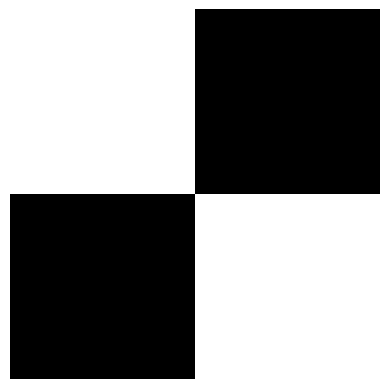

In [2]:
import matplotlib.pyplot as plt

plt.imshow(image1)
plt.axis("off") # Not to show the axis
plt.show()

This can just be a zoom of an image of 4 pixelThis could simply be a zoomed-in view of an image with 4 pixels. In a real-world scenario, the pixels are very small (i.e., there are many pixels in a single image), and we can represent complex figures using larger matrices. If the number of pixels per inch increases, the image quality improves.
    
Note: When describing colored images, we typically use the *RGB* model, although other models exist, even if they are less commonly used.

Let's open and display an image using Pyhton code:

<class 'numpy.ndarray'>
[123  81  43]


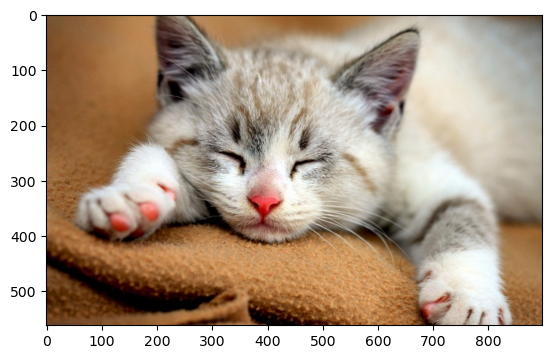

In [3]:
# Load an image
cat_image = plt.imread('images/img2.jpg')
print(type(cat_image))
print(cat_image[0,0]) # printing top left pixel

# Display the image
plt.imshow(cat_image)
plt.show()

`plt.imread()` converts the image into a `numpy.ndarray`, representing each pixel as a triplets of values in $\{0,...,255\}$, forming a $3D$ matrix.

That's essentially it for the representation. We now have our array, where the channel values (R, G, B) of each pixel can be accessed as elements of the array. From there, we can create slices, manipulate colors, pass the data into functions, and more.

## Manipulations

You will often need to manipulate these NumPy arrays. For basic operations, refer to the complete NumPy documentation.

### Color manipulations

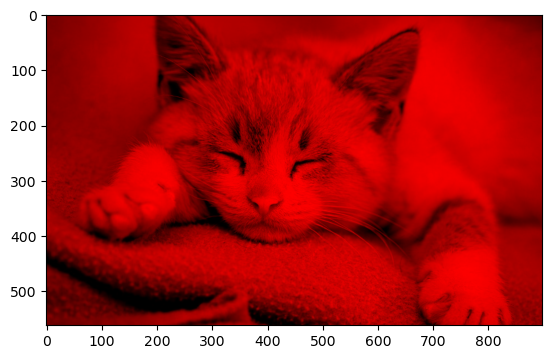

In [4]:
red_image = cat_image.copy() # Copy the image
red_image[:, :, 1] = 0 # Equivalent to forall i,j red_image[i,j,1] = 0
red_image[:, :, 2] = 0 # Equivalent to forall i,j red_image[i,j,1] = 2

plt.imshow(red_image)
plt.show()

### Greyscale (Black & White) images

Greyscale images are often used to represent images with less data while maintaining high accuracy, as color is not always essential.

In greyscale images, each pixel is represented by a single value (indicating the intensity of black) instead of three values (R, G, and B). To convert an image to greyscale, we can take the average of the three color channel values.

82.33333333333333


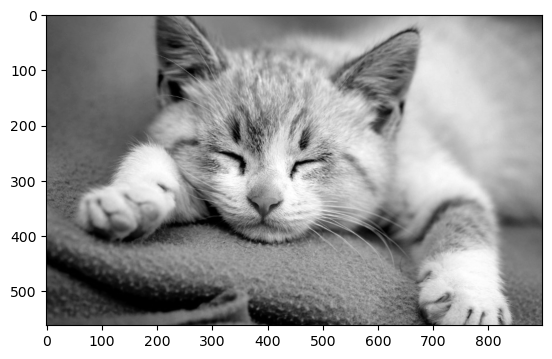

In [5]:
import numpy as np

def gray_level(img):
    return img[:,:,0]/3 + img[:,:,1]/3 + img[:,:,2]/3

grey_cat_image = gray_level(cat_image)
print(grey_cat_image[0,0])
plt.imshow(grey_cat_image, cmap='gray') # cmap="gray" is to tell that we have an greyscale image
plt.show()

You can also use the `cv2` package and open image directly in a greyscale format with the option `cv2.IMREAD_GRAYSCALE`.

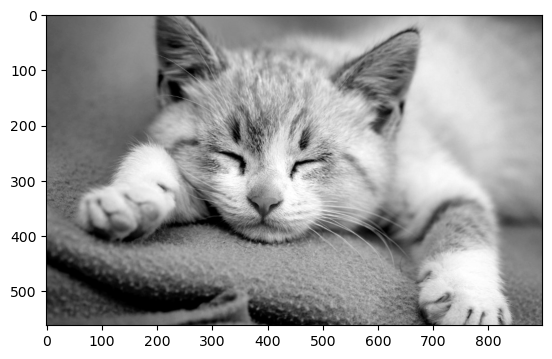

In [6]:
import cv2

img = cv2.imread('images/img2.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")
plt.show()

Here, we simply took the average of the three color channels, but this does not accurately reflect how the human eye perceives color. In reality, the human eye is less sensitive to blue than to red. Below is a function that better represents a greyscale image as perceived by the human eye.

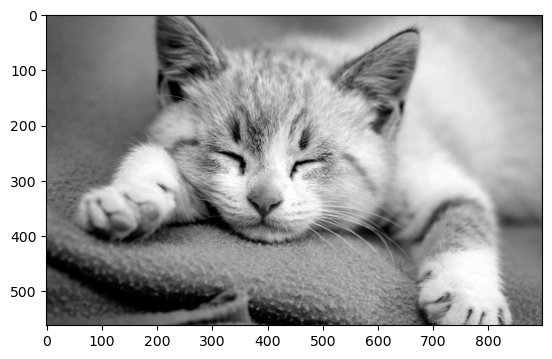

In [7]:
grey_cat_image2 = 0.21*cat_image[:,:,0] + 0.72*cat_image[:,:,1] + 0.07*cat_image[:,:,2]
plt.imshow(grey_cat_image2, cmap="gray")
plt.show()

### Crop

When working with AI models, you always want to minimize the amount of data to reduce training time and remove unnecessary information. For example, in the following image, there are many useless white pixels that we do not need to consider.
<img src="images/uncropped.png" alt="drawing" width="600"/>

Therefore, we will crop the image to reduce its size as much as possible while preserving all useful pixels—that is, pixels that are not white. A pixel is considered "white" if its value (ranging from $0$ to $1$ in a greyscale image) is greater than a fixed threshold close to $1$.

(293, 1550)


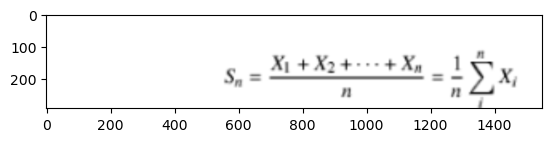

(197, 948)


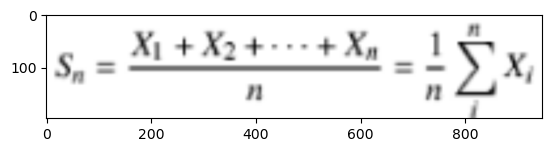

In [8]:
def crop(arr, wb=1, k=0):
    # Crop a greyscale image
    # wb is the white bound
    # k represent the amount of pixels we keep on the side
    n,m = arr.shape
    x, X, y, Y = n, 0, m, 0
    for i in range(n):
        for j in range(m):
            if arr[i,j]<wb:
                x = min(x, i)
                X = max(X, i)
                y = min(y, j)
                Y = max(Y, j)
    
    return arr[max(x-k,0):min(X+k,n), max(y-k,0):min(Y+k,m)]

img = plt.imread("images/uncropped.png")
img = gray_level(img)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

cropped = crop(img, wb=0.95, k=15)
print(cropped.shape)
plt.imshow(cropped, cmap="gray")
plt.show()

Note that the previous code cell took approximately 1.3 seconds which is quite slow. This is due to the fact that basics Python loops are very inefficient. Here is a more efficient approach using `cv2.threshold` which takes around 0.1 seconds.

`cv2.threshold` takes $4$ arguments:
 - The greyscale image in a `ndarray` format.
 - A bound $B \in [0,1]$.
 - A value $V \in \{0,...,255\}$.
 - A `cv2` argument $A$.

The function return two values $r$ and $T$. $r$ is equal to your bound $B$. And $T$ is a copy of your image where each pixel with a value $\leq B$ is transformed to $V$, and the other are transformed to $0$ and considered unchanged. If $A$ is `cv2.THRESH_BINARY` this is the expected behavior. If $A$ is `cv2.THRESH_BINARY_INV$, it does the opposite, i.e. it transfoms pixels with values $> B$.

`numpy.argwhere(T)` returns the set of changed coordinates.

(293, 1550)


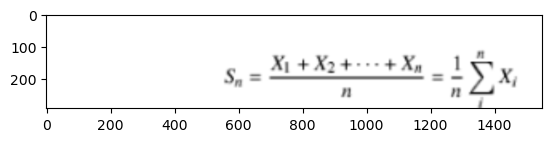

(197, 948)


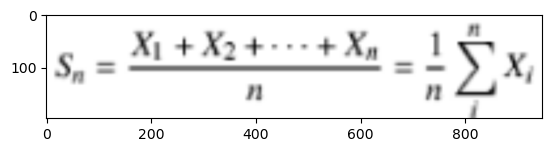

In [9]:
def crop(img, wb=0.95, k=0):
    n,m = img.shape
    _, thresh = cv2.threshold(img, wb, 255, cv2.THRESH_BINARY_INV)
    white_pt_coords = np.argwhere(thresh)

    x = min(white_pt_coords[:,0])
    y = min(white_pt_coords[:,1])
    X = max(white_pt_coords[:,0])
    Y = max(white_pt_coords[:,1])

    return img[max(x-k,0):min(X+k,n), max(y-k,0):min(Y+k,m)]


img = plt.imread("images/uncropped.png")
img = gray_level(img)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

cropped = crop(img, wb=0.95, k=15)
print(cropped.shape)
plt.imshow(cropped, cmap="gray")
plt.show()

### Unblur images

You may encounter issues when your images are too blurry. Therefore, we provide a method to unblur images.

In [10]:
def unblur_rgb_arr(arr, size=20):
    # Unblur an RBG image
    def gaussian_grow(kernel):
        s = kernel.shape
        res = np.zeros((s[0]+1,s[1]+1))
        res[:-1,:-1] = kernel
        res[1: ,:-1] += kernel
        res[:, 1:] += res[:, :-1]
        return res

    def gaussian_kernel(size):
        # Approximate a guassian grow by binomial coefficient
        g = np.ones((1,1))
        for _ in range(size-1):
            g = gaussian_grow(g)
        return g

    def img_pad(img, padl, padc = None):
        # Pad an image
        if padc is None:
            padc = padl
        return np.pad(img, [(padl,padl),(padc,padc),*[(0,0) for _ in img.shape[2:]]], mode='edge')

    def apply_kernel(img, kernel):
        # Apply a kernel to an image
        sk = kernel.shape
        ps = [int(s/2) for s in sk]
        si = img.shape
        padded_image = img_pad(img, ps[0], ps[1])
        res = np.zeros(img.shape)
        for i in range(sk[0]):
            for j in range(sk[1]):
                res += kernel[sk[0]-i-1,sk[1]-j-1] * padded_image[i:i+si[0],j:j+si[1]]
        return res

    # Kernel to smooth (blur) the image
    kernel = gaussian_kernel(size)
    kernel /= np.sum(kernel)

    # Identity filter, doing nothing
    identity = np.zeros((size,size))
    identity[1,1] = 1

    # Details kernel: substracting the smoothed image from the original image
    details = identity - kernel
    kernel = identity + size*details # Emphasizing the details

    arr_sharp = np.clip(apply_kernel(arr, kernel), 0, 1)
    return arr_sharp

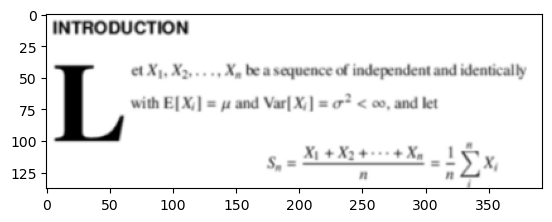

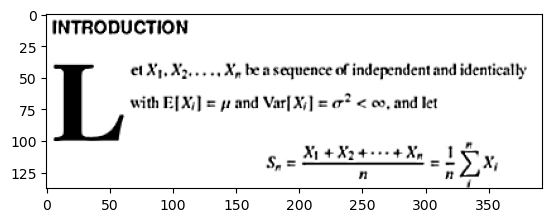

In [11]:
img = plt.imread("images/ex1_blur.png")
plt.imshow(img)
plt.show()

unblur_img = unblur_rgb_arr(img, size=4)
# Depending of the image, you will have to play and change the parameter 'size'
plt.imshow(unblur_img)
plt.show()

## Augmentation

Many deep learning projects focus on processing images. A well-known example, still under development, is creating an AI model to translate images from scientific papers into LaTeX or Markdown code. Unfortunately, the papers you want to translate may not be perfect—they can be slightly blurred, rotated, deformed, and so on. For example, scanned papers or images are often imperfect. This highlights the importance of training AI models on data that includes some level of imperfection.

The goal of this tutorial is to introduce various methods for modifying images. These modifications are inspired by a research paper: https://arxiv.org/pdf/2308.13418

![alt text](images/ex1_original.png "Title")
![alt text](images/ex1_blur.png "Title")

All the transformation will be performed using the python package `Albumentation`.

Here is a list of possible imperfection that may appear in images:
 - Dilatation : `Morphological(operation='dilation')`
 - Grid distortion : `GridDistortion()`
 - Image compression : `ImageCompression()`
 - Affine transformation : `Affine()`
 - Erosion : `Morphological(operation='erosion')`
 - Shift scale rotation : `Affine()` with some options you want
 - Brightness contrast : `RandomBrightnessContrast()`
 - Blur : `Blur()`

To use `Albumentations`, we need to create a `Compose` object that contains all possible transformations and their respective probabilities of occurring.

In [12]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=1) # Flip the image with probability 1
    ])

/home/maceo/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we can apply our `Compose` object to the image we want.

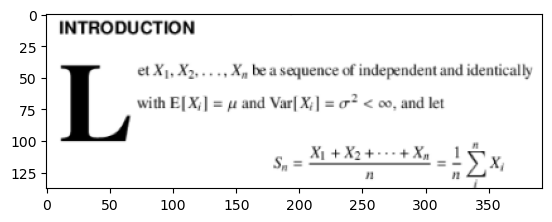

<class 'dict'> dict_keys(['image'])


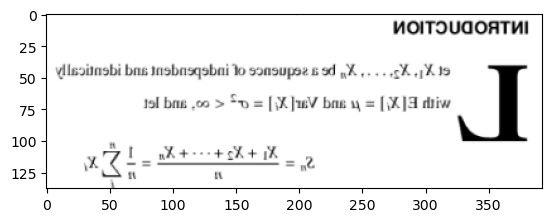

In [13]:
img = plt.imread("images/ex1_original.png")
plt.imshow(img)
plt.show()


transformed = transform(image=img) # transformed is a map containing a unique key: 'image'
print(type(transformed), transformed.keys())
transformed_image = transformed['image']

plt.imshow(transformed_image)
plt.show()

To plot both original and transformed image next to each other, we can use the following function.

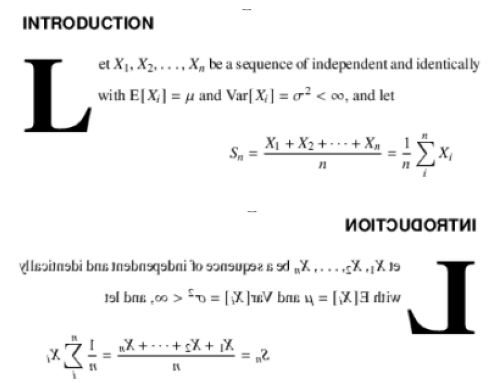

In [14]:
def plot_2_images(original, transformed):
    f, axarr = plt.subplots(2) # We are dividing the plot screeen into 2 parts
    axarr[0].imshow(original)
    axarr[0].axis("off")
    axarr[1].imshow(transformed)
    axarr[1].axis("off")
    plt.show()

plot_2_images(img, transformed_image)

### Tutorial

TODO: using the `random` (or `numpy.random`) python packages, create $N$ images with random scale, shift and rotation transformation. Then plot them all at ones.

First, we will create a function that return a transformed images wit arbitrary (pseudo realistic) parameters.

In [15]:
import random as rd

def generate_shift_scale_rotate_image(img):
    # scale is a float between 0 and 1
    # But here, we only want a scale that is between 0.8 and 1
    rd_scale = rd.random()/5 + 0.8

    # rotate is a float between -360 and 360
    # But here, we only wants rotations bewteen -20 and 20
    rd_rotate = rd.randint(-10, 10)

    # translate_percent is a float between 0 and 1
    # But here, we only wants rotations bewteen 0 and 20
    rd_translation = rd.random()/5
    
    transform = A.Compose([
        A.Affine(p=1, 
            scale=rd_scale,
            rotate=rd_rotate,
            translate_percent=rd_translation)
        ])
    return transform(image=img)["image"]

Then we will create a function that plot every images from a list in a square sufficiently large to fit all images. Note that if the list is composed of $N$ images, we want the smallest integer $n$ such that $n^2 \geq N$. Therefore, we will take $n = \lceil \sqrt{N} \rceil$

In [16]:
import math

def plot_images(images_list, show_axis=True):
    N = len(images_list)
    n = int(math.ceil(math.sqrt(N)))

    _, axarr = plt.subplots(n,n) # We are dividing the plot screeen into n x n parts
    for i in range(n):
        for j in range(n):
            if i*n +j < len(images_list): # Test if there is still images to plot
                axarr[i][j].imshow(images_list[i*n +j])
            if not show_axis:
                axarr[i][j].axis("off")
    plt.show()

Finally, we can generate and plot our images.

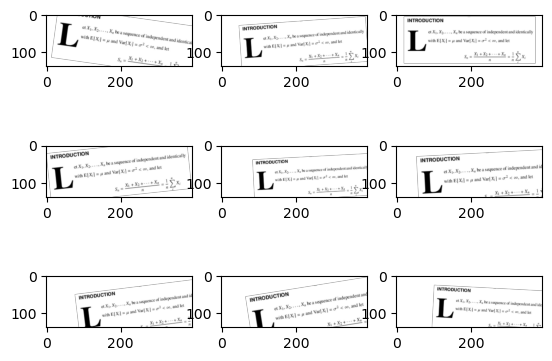

In [17]:
N = 9
transformed_images = [generate_shift_scale_rotate_image(img) for _ in range(N)]
plot_images(transformed_images, show_axis=True)